<a href="https://colab.research.google.com/github/sallmamostaffa/Chinook/blob/main/Chinook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sqlalchemy import create_engine # type: ignore
import pandas as pd # type: ignore

# Define the connection string
server = 'DESKTOP-R753PEO'
database = 'Chinook_AutoIncrement'

engine = create_engine(f'mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&Trusted_Connection=yes')

In [ ]:
connection = engine.connect()

In [ ]:
###cleaning employee table
clean_query ="SELECT * FROM Employee"
clean_employee = pd.read_sql(clean_query, connection)

In [ ]:
clean_employee.drop_duplicates(inplace=True)
print(clean_employee.isnull().sum())

EmployeeId    0
LastName      0
FirstName     0
Title         0
ReportsTo     1
BirthDate     0
HireDate      0
Address       0
City          0
State         0
Country       0
PostalCode    0
Phone         0
Fax           0
Email         0
dtype: int64


In [ ]:
clean_employee['ReportsTo'].fillna(0)
clean_employee['Phone'] = clean_employee['Phone'].apply(lambda x: "+" + x if not x.startswith('+') else x)
clean_employee['Fax'] = clean_employee['Fax'].apply(lambda x: '+1' + x[1:] if x.startswith('1') else x)
print(clean_employee.head())

   EmployeeId LastName FirstName                Title  ReportsTo  BirthDate  \
0           1    Adams    Andrew      General Manager        NaN 1962-02-18   
1           2  Edwards     Nancy        Sales Manager        1.0 1958-12-08   
2           3  Peacock      Jane  Sales Support Agent        2.0 1973-08-29   
3           4     Park  Margaret  Sales Support Agent        2.0 1947-09-19   
4           5  Johnson     Steve  Sales Support Agent        2.0 1965-03-03   

    HireDate              Address      City State Country PostalCode  \
0 2002-08-14  11120 Jasper Ave NW  Edmonton    AB  Canada    T5K 2N1   
1 2002-05-01         825 8 Ave SW   Calgary    AB  Canada    T2P 2T3   
2 2002-04-01        1111 6 Ave SW   Calgary    AB  Canada    T2P 5M5   
3 2003-05-03     683 10 Street SW   Calgary    AB  Canada    T2P 5G3   
4 2003-10-17         7727B 41 Ave   Calgary    AB  Canada    T3B 1Y7   

               Phone                Fax                     Email  
0  +1 (780) 428-9482  +1

In [ ]:
###cleaning the customer table
clean_customer = pd.read_sql("SELECT * FROM Customer", connection)
print(clean_customer.isnull().sum())

CustomerId       0
FirstName        0
LastName         0
Company         49
Address          0
City             0
State           29
Country          0
PostalCode       4
Phone            1
Fax             47
Email            0
SupportRepId     0
dtype: int64


In [ ]:
clean_customer = clean_customer.drop(columns=['Fax', 'State'])
clean_customer['Company'] = clean_customer["Company"].fillna('No company')

In [ ]:
print(clean_customer.columns)
print(clean_customer.head())

Index(['CustomerId', 'FirstName', 'LastName', 'Company', 'Address', 'City',
       'Country', 'PostalCode', 'Phone', 'Email', 'SupportRepId'],
      dtype='object')
   CustomerId  FirstName     LastName  \
0           1       Luís    Gonçalves   
1           2     Leonie       Köhler   
2           3   François     Tremblay   
3           4      Bjørn       Hansen   
4           5  František  Wichterlová   

                                            Company  \
0  Embraer - Empresa Brasileira de Aeronáutica S.A.   
1                                        No company   
2                                        No company   
3                                        No company   
4                                  JetBrains s.r.o.   

                           Address                 City         Country  \
0  Av. Brigadeiro Faria Lima, 2170  São José dos Campos          Brazil   
1          Theodor-Heuss-Straße 34            Stuttgart         Germany   
2                1498 rue Bélang

In [ ]:
###cleaning Invoice table
clean_invoice = pd.read_sql("select * from Invoice", connection)
clean_invoice = clean_invoice.drop(columns='BillingState')
clean_invoice["BillingPostalCode"] = clean_invoice["BillingPostalCode"].fillna("No postal")

In [ ]:
print(clean_invoice.head())

   InvoiceId  CustomerId InvoiceDate           BillingAddress BillingCity  \
0          1           2  2021-01-01  Theodor-Heuss-Straße 34   Stuttgart   
1          2           4  2021-01-02         Ullevålsveien 14        Oslo   
2          3           8  2021-01-03          Grétrystraat 63    Brussels   
3          4          14  2021-01-06           8210 111 ST NW    Edmonton   
4          5          23  2021-01-11          69 Salem Street      Boston   

  BillingCountry BillingPostalCode  Total  
0        Germany             70174   1.98  
1         Norway              0171   3.96  
2        Belgium              1000   5.94  
3         Canada           T6G 2C7   8.91  
4            USA              2113  13.86  


In [ ]:
country_revenue_query = "SELECT BillingCountry, SUM(Total) AS TotalRevenue \
        FROM Invoice \
        GROUP BY BillingCountry \
        ORDER BY TotalRevenue DESC"
country_revenue = pd.read_sql(country_revenue_query, connection)
#print(country_revenue.head())

In [ ]:
q1 = "SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalPurchases FROM Customer c \
            JOIN Invoice i ON c.CustomerId = i.CustomerId \
            GROUP BY c.CustomerId, c.FirstName, c.LastName;"
customer_data  = pd.read_sql(q1, connection)
#print(customer_data.head())

In [ ]:
q2 = "SELECT g.Name AS Genre, SUM(il.UnitPrice * il.Quantity) AS TotalSales \
            FROM InvoiceLine il \
            JOIN Track t ON il.TrackId = t.TrackId \
            JOIN Genre g ON t.GenreId = g.GenreId \
            GROUP BY g.Name \
            ORDER BY TotalSales DESC;"
sales_by_genre  = pd.read_sql(q2, connection)
#print(sales_by_genre.head())

In [ ]:
q3 = "SELECT MONTH(InvoiceDate) as Months, SUM(total) AS Total_Sales \
            FROM Invoice \
            GROUP BY MONTH(InvoiceDate) \
            ORDER BY Months;"
monthly_sales_trends  = pd.read_sql(q3, connection)
print(monthly_sales_trends.head())

   Months  Total_Sales
0       1       201.12
1       2       187.20
2       3       195.10
3       4       198.14
4       5       193.10


In [ ]:
customer_data['ValueSegment'] = pd.cut(customer_data['TotalPurchases'], bins=[0, 38, 40, 45, float('inf')],
                                        labels=['Low Value', 'Medium Value', 'High Value', 'VIP'])

customer_data['PurchaseFrequency'] = pd.cut(customer_data['TotalPurchases'],
                                    bins=[0, 38, 40, 45, float('inf')],
                                    labels=['Rare', 'Occasional', 'Frequent', 'Loyal'])

In [ ]:
print(customer_data.head())

   CustomerId  FirstName     LastName  TotalPurchases  ValueSegment  \
0           1       Luís    Gonçalves           39.62  Medium Value   
1           2     Leonie       Köhler           37.62     Low Value   
2           3   François     Tremblay           39.62  Medium Value   
3           4      Bjørn       Hansen           39.62  Medium Value   
4           5  František  Wichterlová           40.62    High Value   

  PurchaseFrequency  
0        Occasional  
1              Rare  
2        Occasional  
3        Occasional  
4          Frequent  


In [ ]:
#Save the cleaned dataset into a CSV file
customer_data.to_csv('cleaned_customer_data.csv', index=False)
monthly_sales_trends.to_csv('monthly_sales_data.csv', index=True)
sales_by_genre.to_csv('genre_sales_data.csv', index=False)
country_revenue.to_csv('country_revenue_data.csv', index=False)


In [ ]:
#Output the head of cleaned data
print(customer_data.head())
print(monthly_sales_trends.head())
print(sales_by_genre.head())
print(country_revenue.head())

   CustomerId  FirstName     LastName  TotalPurchases  ValueSegment  \
0           1       Luís    Gonçalves           39.62  Medium Value   
1           2     Leonie       Köhler           37.62     Low Value   
2           3   François     Tremblay           39.62  Medium Value   
3           4      Bjørn       Hansen           39.62  Medium Value   
4           5  František  Wichterlová           40.62    High Value   

  PurchaseFrequency  
0        Occasional  
1              Rare  
2        Occasional  
3        Occasional  
4          Frequent  
   Months  Total_Sales
0       1       201.12
1       2       187.20
2       3       195.10
3       4       198.14
4       5       193.10
                Genre  TotalSales
0                Rock      826.65
1               Latin      382.14
2               Metal      261.36
3  Alternative & Punk      241.56
4            TV Shows       93.53
  BillingCountry  TotalRevenue
0            USA        523.06
1         Canada        303.96
2     

In [ ]:
##get top-selling artists by revenue
q4 = """
SELECT ar.Name AS Artist, SUM(il.UnitPrice * il.Quantity) AS TotalSales
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
JOIN Album al ON t.AlbumId = al.AlbumId
JOIN Artist ar ON al.ArtistId = ar.ArtistId
GROUP BY ar.Name
ORDER BY TotalSales DESC;
"""
top_artists_by_revenue = pd.read_sql(q4, connection)
top_artists_by_revenue.to_csv('top_artists_by_revenue.csv', index=False)
print(top_artists_by_revenue.head())


         Artist  TotalSales
0   Iron Maiden      138.60
1            U2      105.93
2     Metallica       90.09
3  Led Zeppelin       86.13
4          Lost       81.59


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")

customer_data = pd.read_csv('cleaned_customer_data.csv')
monthly_sales_trends = pd.read_csv('monthly_sales_data.csv')
sales_by_genre = pd.read_csv('genre_sales_data.csv')
country_revenue = pd.read_csv('country_revenue_data.csv')
top_artists_by_revenue = pd.read_csv('top_artists_by_revenue.csv')

C:\Users\original\AppData\Local\Temp\ipykernel_19936\2940616302.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPurchases', y='FirstName', data=top_customers, palette="viridis")


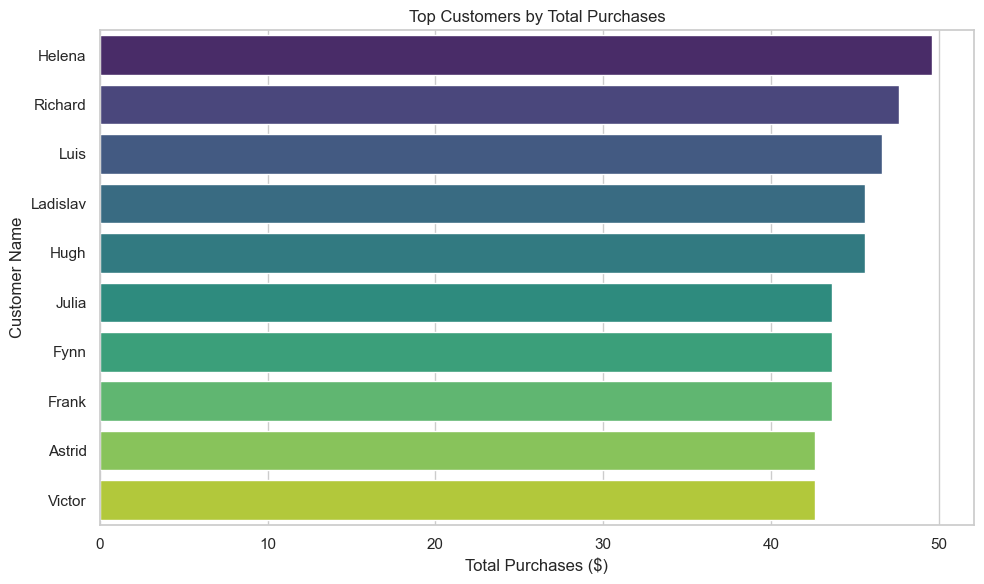

In [ ]:
##Top Customers by Total Purchases
plt.figure(figsize=(10, 6))
top_customers = customer_data.sort_values('TotalPurchases', ascending=False).head(10)
sns.barplot(x='TotalPurchases', y='FirstName', data=top_customers, palette="viridis")
plt.title('Top Customers by Total Purchases')
plt.xlabel('Total Purchases ($)')
plt.ylabel('Customer Name')
plt.tight_layout()
plt.savefig('top_customers_by_purchases.png')
plt.show()

C:\Users\original\AppData\Local\Temp\ipykernel_19936\4191864776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalSales', y='Genre', data=sales_by_genre, palette="coolwarm")


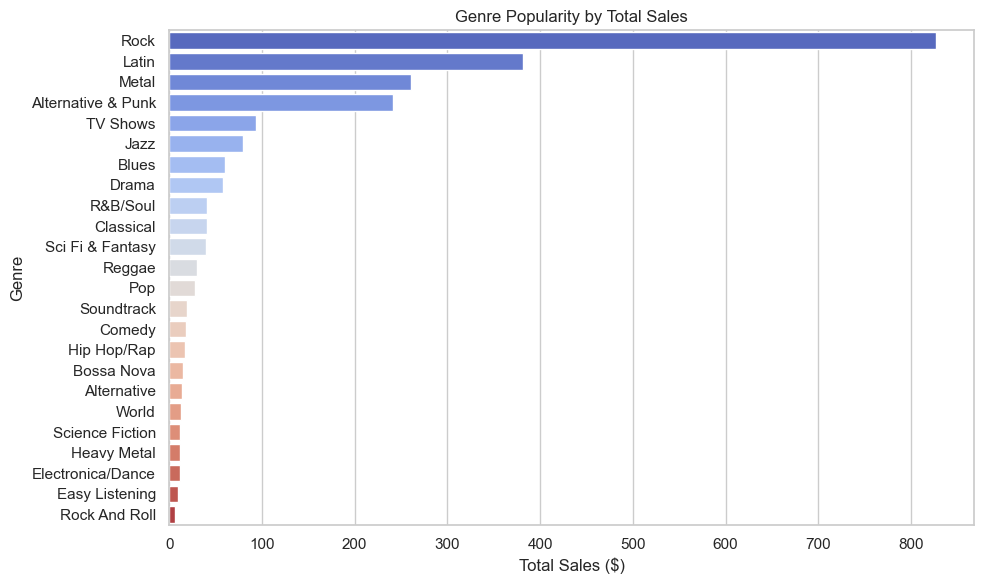

In [ ]:
##Genre Popularity by Total Sales
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalSales', y='Genre', data=sales_by_genre, palette="coolwarm")
plt.title('Genre Popularity by Total Sales')
plt.xlabel('Total Sales ($)')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('genre_popularity_by_sales.png')
plt.show()


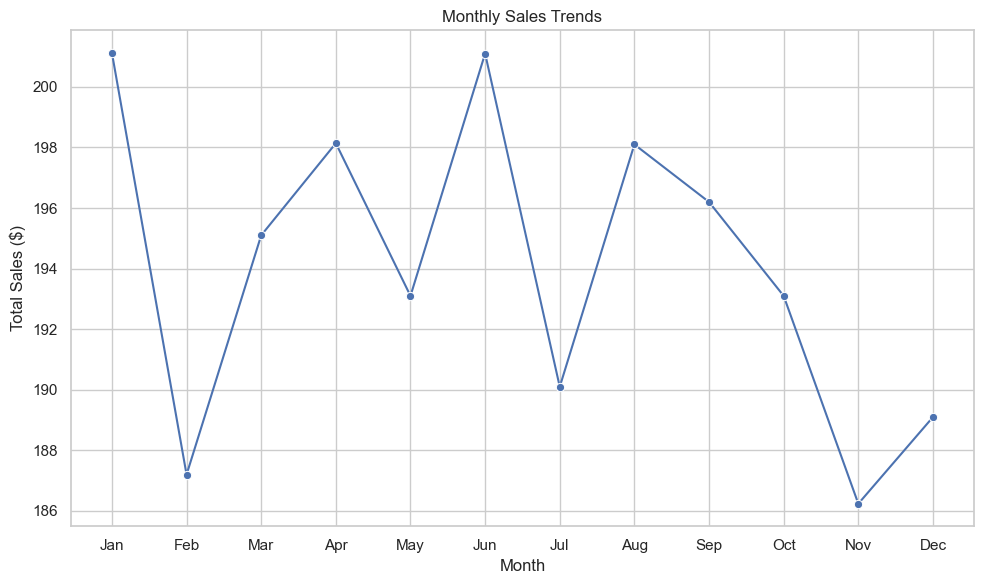

In [ ]:
##Monthly Sales Trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='Months', y='Total_Sales', data=monthly_sales_trends, marker="o", color="b")
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.savefig('monthly_sales_trends.png')
plt.show()

C:\Users\original\AppData\Local\Temp\ipykernel_19936\626601263.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalSales', y='Artist', data=top_artists_by_revenue.head(10), palette="magma")


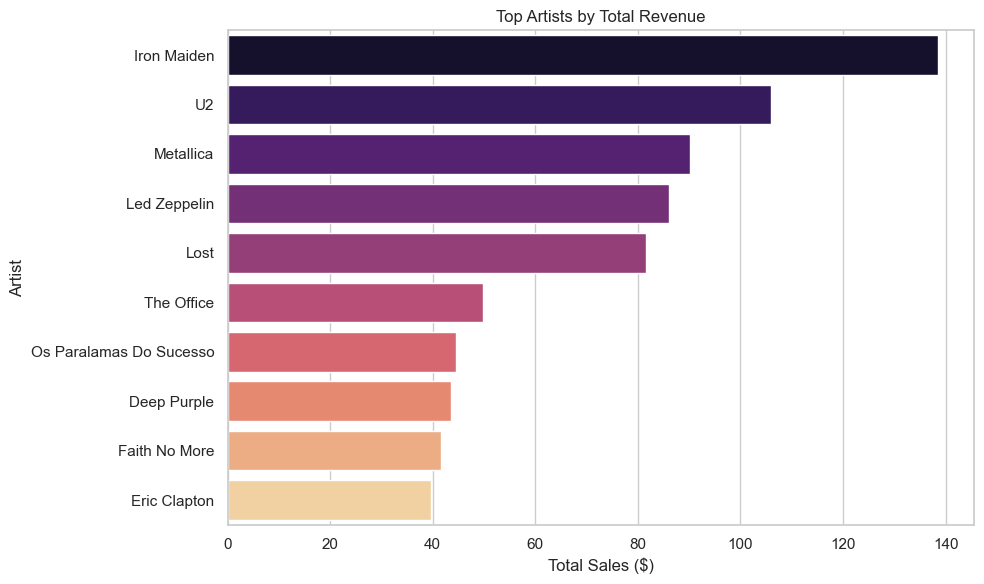

In [ ]:
##Top Artists by Revenue
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalSales', y='Artist', data=top_artists_by_revenue.head(10), palette="magma")
plt.title('Top Artists by Total Revenue')
plt.xlabel('Total Sales ($)')
plt.ylabel('Artist')
plt.tight_layout()
plt.savefig('top_artists_by_revenue.png')
plt.show()

C:\Users\original\AppData\Local\Temp\ipykernel_19936\2345362637.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalRevenue', y='BillingCountry', data=country_revenue, palette="Blues_d")


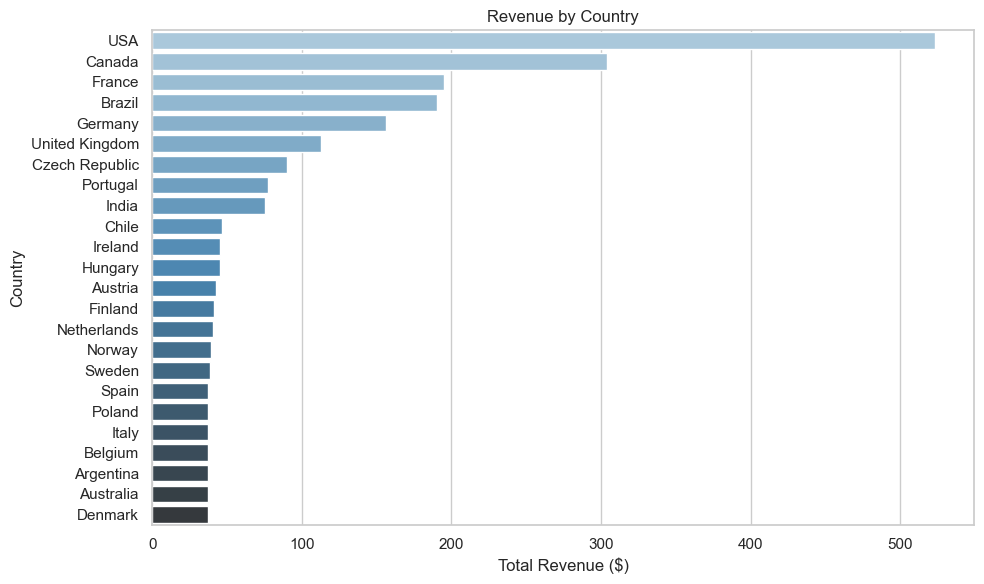

In [ ]:
##Revenue by Country
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalRevenue', y='BillingCountry', data=country_revenue, palette="Blues_d")
plt.title('Revenue by Country')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Country')
plt.tight_layout()
plt.savefig('revenue_by_country.png')
plt.show()